**ROUND : DATA SCIENCE CASE-STUDY** 

                                      Name - Naman Singh Chandel
                                      unroll- 171500202

In [1]:
#Importing some basic libraries for Loading the  data and for data visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [43]:
data = pd.read_csv("/content/drive/My Drive/train.csv") # importing the Beer Rating dataset
data.head()

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,NaN,NaN,NaN,NaN,BeerSox
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,NaN,NaN,NaN,Male,mschofield
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,1.209827e+09,"Aug 10, 1976",208508400.0,Male,molegar76
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,NaN,NaN,NaN,NaN,Brewbro000


visualing Data Heatmap by using Seaborn


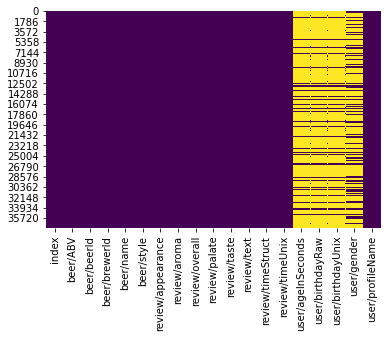

In [4]:
sns.heatmap(data.isnull(),cbar=False,cmap='viridis')

By this Heatmap we can know in which column the data have null values

**EDA : Exploratory Data Analysis Part**

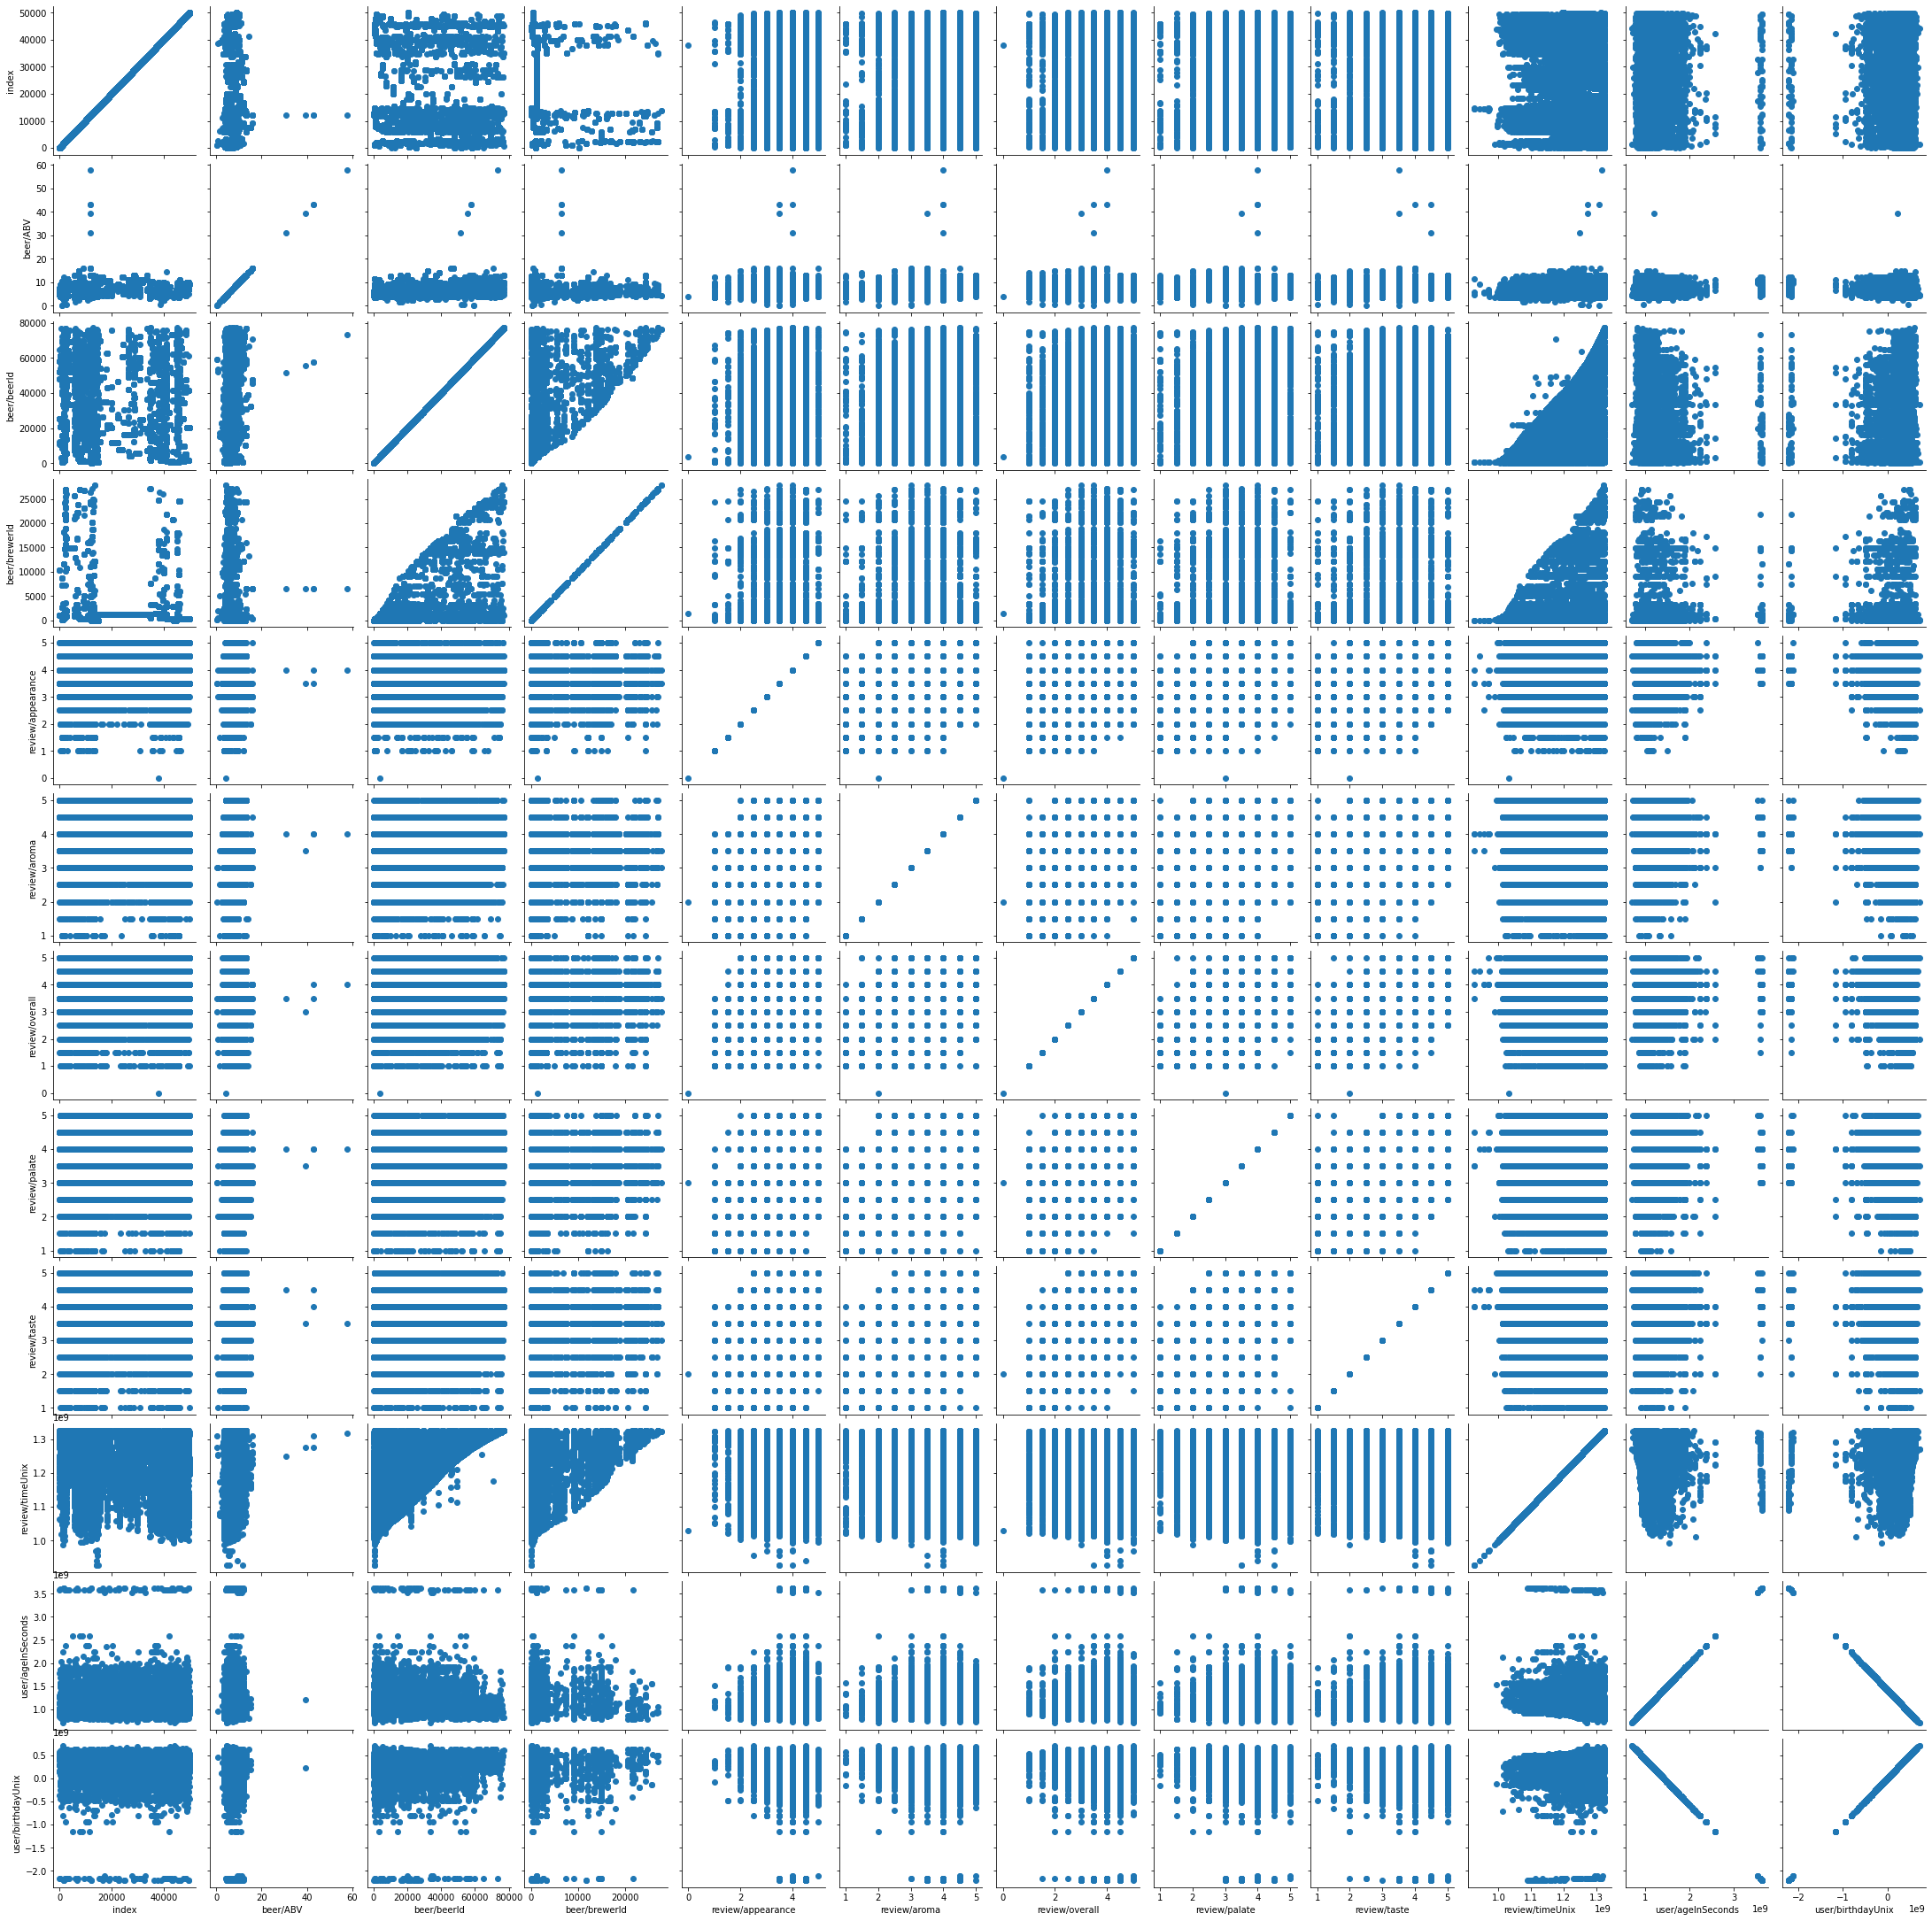

In [25]:
b = sns.PairGrid(data)
b.map(plt.scatter)

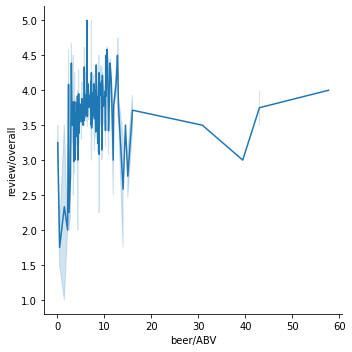

In [22]:
sns.relplot(x='beer/ABV',y='review/overall',data=data,kind='line')

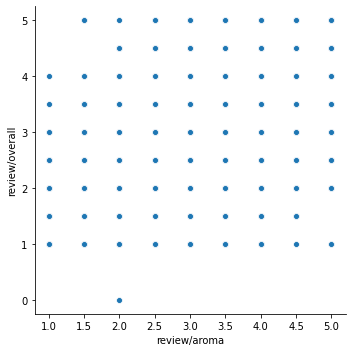

In [23]:
sns.relplot(x='review/aroma',y='review/overall',data=data)

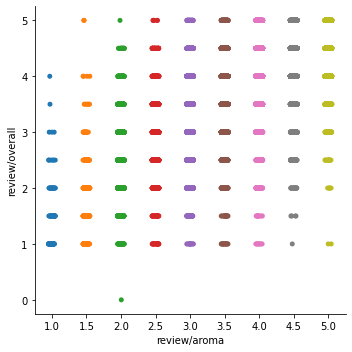

In [20]:
sns.catplot(x='review/aroma',y='review/overall',data=data)

**Feature Seletion Part**


In this Data 'user/ageInSeconds','user/birthdayRaw','user/birthdayUnix','user/gender', are having more than 70% null value(Imputation may cause Imbancing in data, so we can drop these columns)

'index','beer/beerId','beer/brewerId','beer/name','review/timeUnix','user/profileName'

And these columns are not effecting the rating of the Beer so can be droped

In [44]:
data = data.drop(['user/ageInSeconds','user/birthdayRaw','user/birthdayUnix','user/gender','index','beer/beerId','beer/brewerId','beer/name','review/timeUnix','user/profileName'],axis=1)
data.shape

(37500, 9)

**Feature Engineering Part**

From 'review/timeStruct' extracting the month because in month can affect the rating like in summer the beer rating may can less and in winter it can be high

In [0]:
month = []
for i in range(data['review/timeStruct'].shape[0]):
  s = data['review/timeStruct'][i]
  start = s.find('mon')   #finding the index of 'mon' because after this string the month is provided
  val = s[start+5:start+8] 
  if val[2]==',': #if the sliced string have ',' it mean its a single digit number so again str will sliced
    val = val[:2]
  month.append(int(val)) # converting into integer and making a month list


In [46]:
month = pd.Series(month)
data['review_month'] = month # adding the month to the data
data = data.drop(['review/timeStruct'],axis=1)
data.head()

,beer/ABV,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review_month
0,5.0,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,12
1,11.0,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,8
2,4.7,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,11
3,4.4,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,6
4,4.4,English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,3


Now from 'review/text' using Natural Language Processing tecnique to create a sparse matrix of reviews and predicting the 'review/overall' to got to know about how a review is relate and what is the rating of a review

In [0]:
from sklearn.feature_extraction.text import CountVectorizer #Importing CountVectorizer for creating sparse matrix
import re
import string

text = data[['review/overall','review/text']] # creating a seprate DataFrame to work on

x = text['review/text']
y = text['review/overall']

alltext = list(text['review/text'])


text.rename({'review/text':'review'})



def clean_text_round1(text):
  try:
    text = text.lower() # Converting the reviews to lower case
    text = re.sub('\[.*?\]','',text)  # removing unnecessary symbols
    text = re.sub('[%s]'% re.escape(string.punctuation),'',text)
    text = re.sub('\w*\d\w*','',text) # taking only str values
    return text
  except:
    pass
round1 = lambda x: clean_text_round1(x)

dataclean = pd.DataFrame(text['review/text'].apply(round1))



In [48]:
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

a = list(dataclean['review/text'])

clean=[]
ps = PorterStemmer()
for i in a:
  try:
    words = word_tokenize(i)
    z = []
    for w in words:
      z.append(ps.stem(w)) # Stemming each word 
    s = ' '
    res = s.join(z) # making a clean review
    clean.append(res)
  except:
    clean.append(i)

s = pd.Series(clean)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [49]:
text['reviews'] = s
text = text.drop(['review/text'],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
x = text['reviews']
y = text['review/overall']

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y) # Encoding the 'review/overall' for classification model

In [0]:
cv  = CountVectorizer(max_features=525)
features  = cv.fit_transform(x.values.astype('U')) # Creating Sparse Matrix of reviews

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,y)

predict = clf.predict(features)



In [53]:
text_review = pd.Series(predict)
data['text_review'] = text_review
data = data.drop(['review/text'],axis=1)
data.head()

,beer/ABV,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review_month,text_review
0,5.0,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,12,7
1,11.0,American Barleywine,4.0,3.5,3.5,3.5,3.0,8,6
2,4.7,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,11,6
3,4.4,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,6,4
4,4.4,English Pale Ale,4.0,3.0,3.0,3.5,2.5,3,5


In [0]:

data['beer/style'] = encoder.fit_transform(data['beer/style'])

data['review/overall'] = encoder.fit_transform(data['review/overall'])

In [0]:
from sklearn.model_selection import train_test_split
Y = data['review/overall'].values
X = data.drop(['review/overall'],axis=1)
trainx,textx,trainy,testy=train_test_split(X,Y,test_size=.2,random_state=0)

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

clf.fit(trainx,trainy)

predict = clf.predict(textx)

p = list(predict)
l = list(testy)
count = 0
for i in range(len(p)):
  if p[i] == l[i]:
    count += 1

decision_tree_acc = count/len(testy)



In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(trainx,trainy)

predict = clf.predict(textx)

p = list(predict)
l = list(testy)
count = 0
for i in range(len(p)):
  if p[i] == l[i]:
    count += 1

random_forest_acc = count/len(testy)

In [0]:
from sklearn import svm
clf = svm.SVC()

clf.fit(trainx,trainy)

predict = clf.predict(textx)
p = list(predict)
l = list(testy)
count = 0
for i in range(len(p)):
  if p[i] == l[i]:
    count += 1
svm_acc = count/len(testy)

In [0]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(trainx,trainy)

predict = clf.predict(textx)
p = list(predict)
l = list(testy)
count = 0
for i in range(len(p)):
  if p[i] == l[i]:
    count += 1

GaussianNb_ac = count/len(testy)

In [0]:
acc_dict = {'ALOGORITHM_NAME':['Decision Tree','Random Forest','SVM','GaussianNB'],'Accuracy':[decision_tree_acc*100,random_forest_acc*100,svm_acc*100,GaussianNb_ac*100]}
Accuracy = pd.DataFrame.from_dict(acc_dict)



In [71]:
Accuracy

,ALOGORITHM_NAME,Accuracy
0,Decision Tree,99.853333
1,Random Forest,99.640000
2,SVM,92.200000
3,GaussianNB,99.946667
